In [21]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#C70000FF"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"


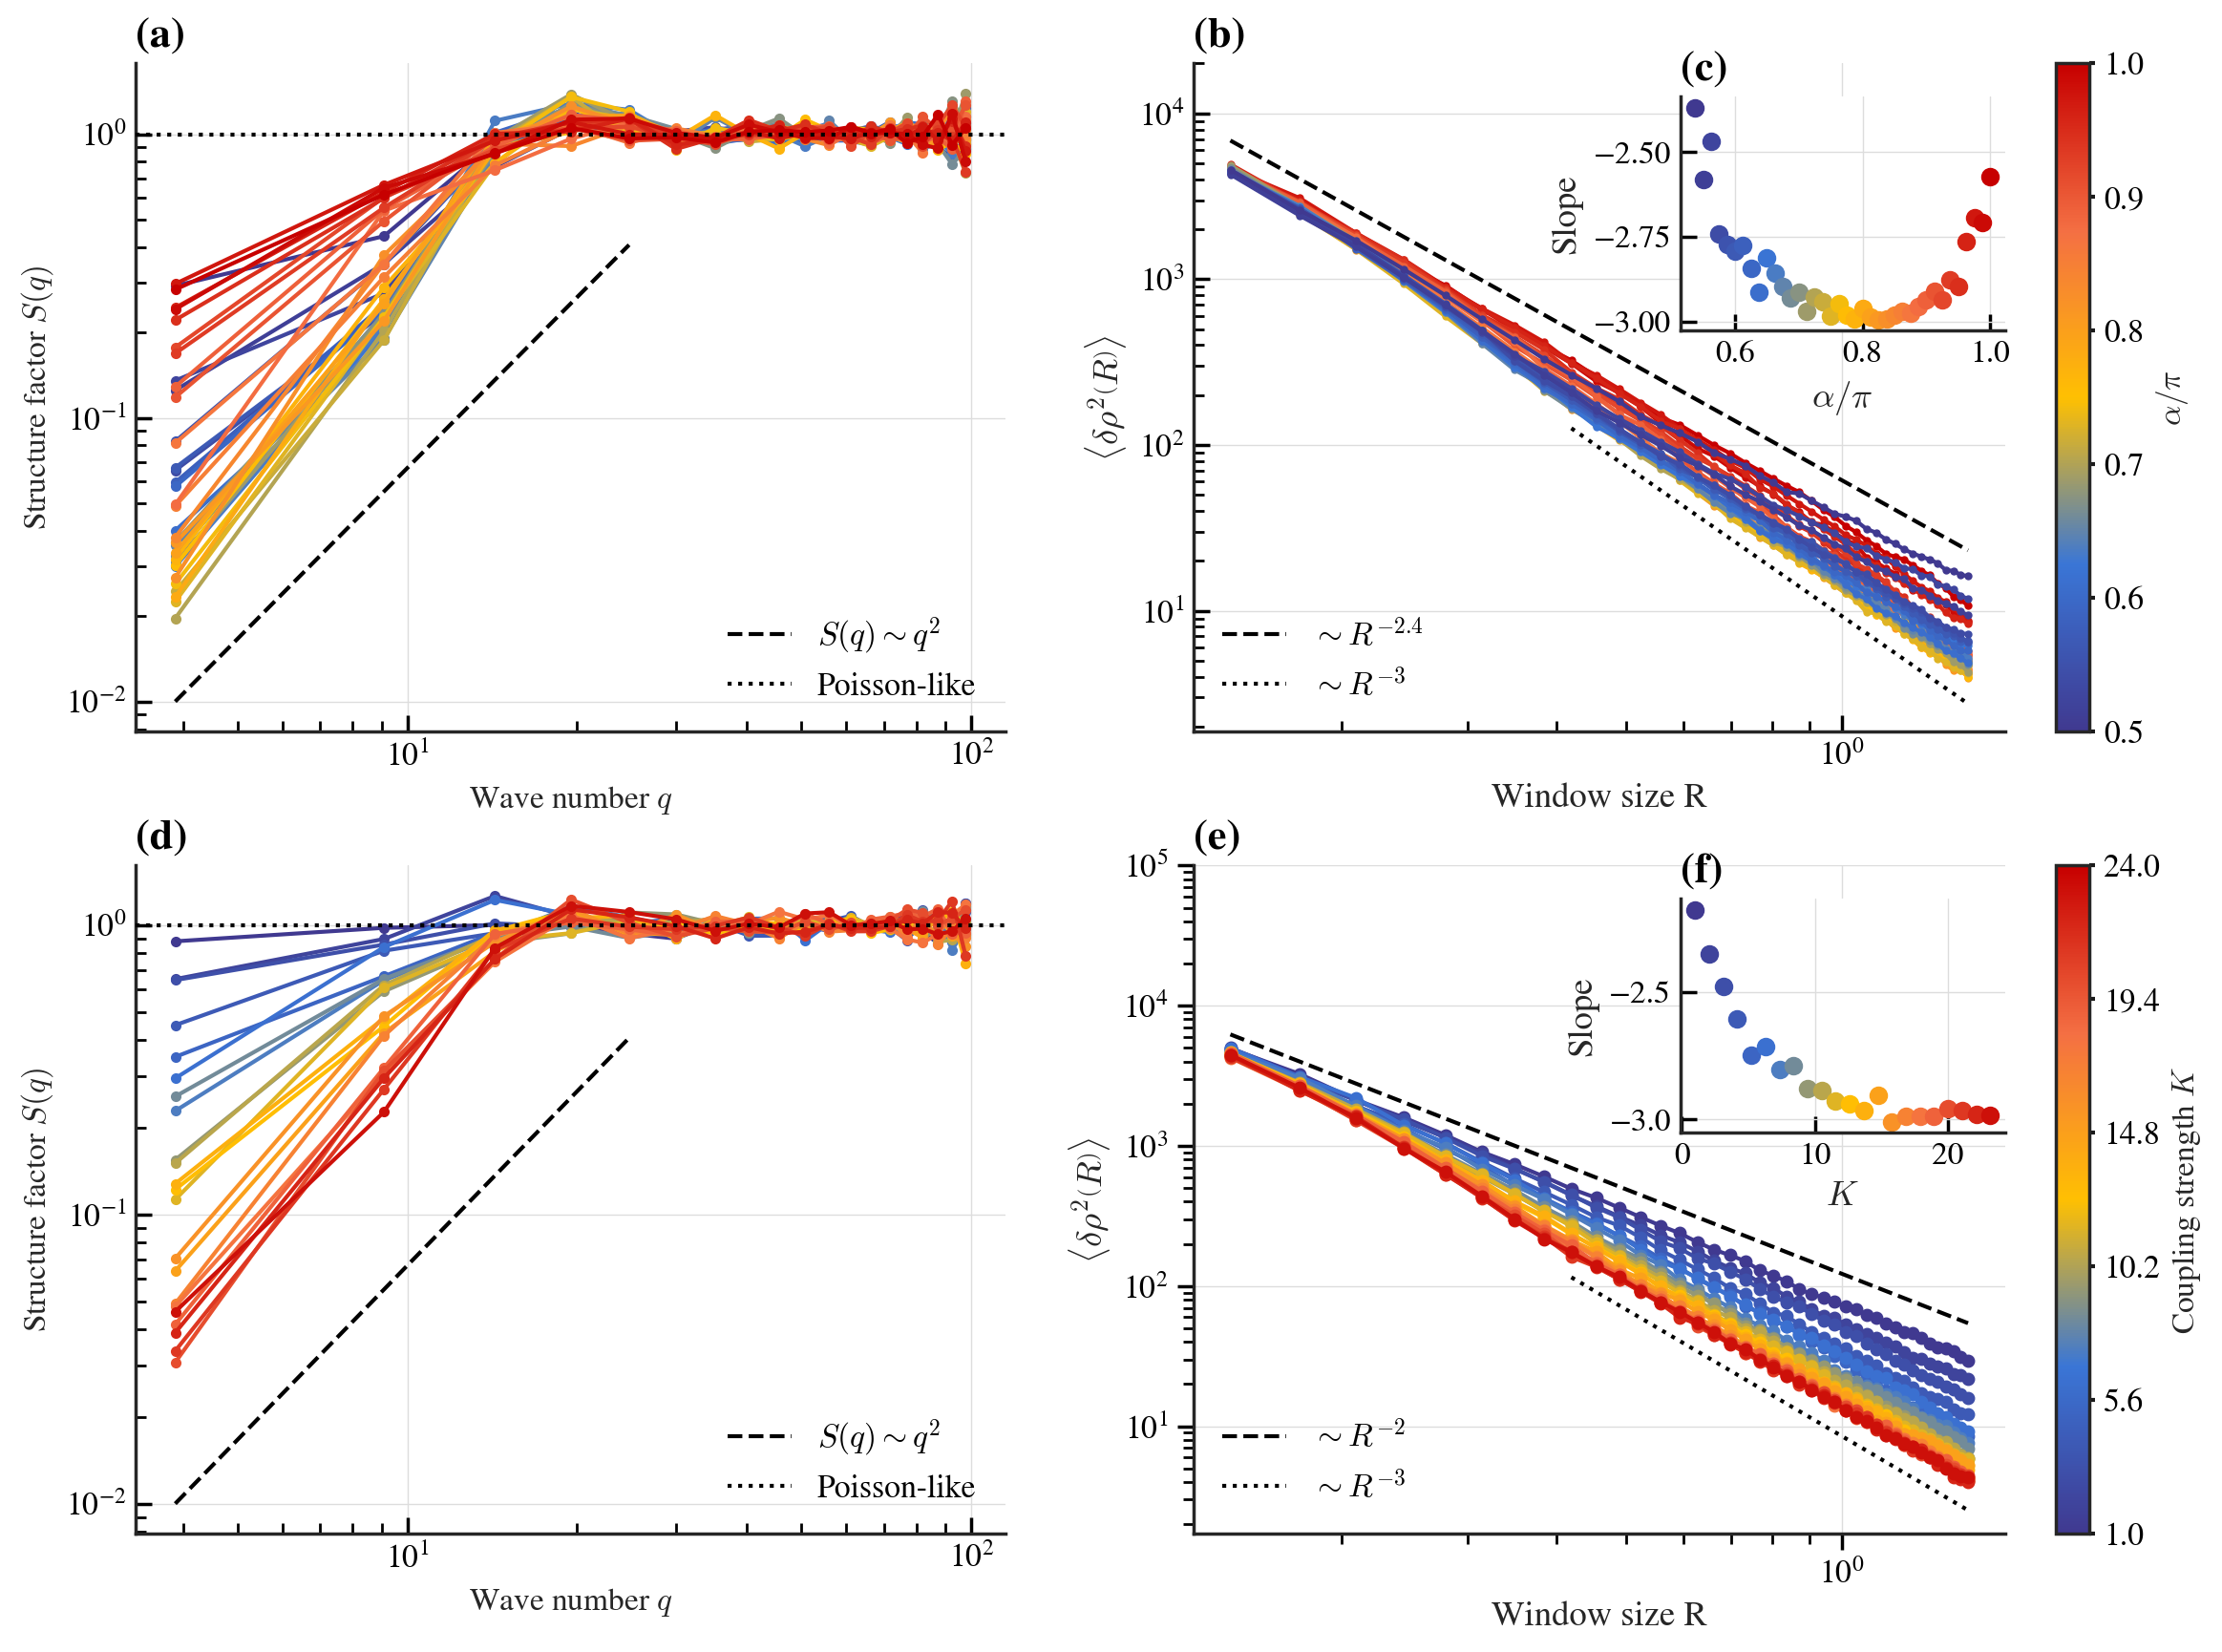

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression

system_size = 7
num_particles = 5000
rho_0 = num_particles / (system_size**2)

# =========================================================================
fig, axs = plt.subplots(2, 2, figsize=(14, 10), width_ratios=[6, 7])
ax: plt.Axes = axs[0, 0]
ax.set_title("(a)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_Sqs_dict_vary_A_K{24}.pkl", "rb") as f:
    mean_Sqs_dict = pickle.load(f)

selectedAlphas = np.linspace(0.5, 1, 41)[3:] * np.pi

for params, (qs, Sqs) in mean_Sqs_dict.items():
    phaseLagA = params[2]
    if phaseLagA not in selectedAlphas:
        continue

    color = cmap((phaseLagA - min(selectedAlphas)) / (max(selectedAlphas) - min(selectedAlphas)))

    qs, Sqs = np.array(qs), np.array(Sqs)
    
    q_bins = np.linspace(qs.min(), qs.max(), 20)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))

    qValues = 0.5 * (q_bins[:-1] + q_bins[1:])
    ax.plot(
        qValues, Sqs_binned[:, 0],
        marker="o", markersize=3, 
        color=color
    )

qValues = 0.5 * (q_bins[:-1] + q_bins[1:])[:5]
power_law = 2
ax.plot(qValues, np.array(qValues) ** power_law / 1500, '--', color="black", 
         markersize=2, linewidth=1.5, label=rf'$S(q) \sim q^{power_law}$')

ax.axhline(1, color='black', linestyle=':', label="Poisson-like", zorder=100)
ax.set_xlabel('Wave number $q$', fontsize=12)
ax.set_ylabel('Structure factor $S(q)$', fontsize=12)
ax.semilogx()
ax.semilogy()
ax.legend(frameon=False, loc="lower right")
ax.grid()
ax.tick_params(which='both', direction="in")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim(None, 50)

# =========================================================================
ax: plt.Axes = axs[0, 1]
ax.set_title("(b)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_variance_rho_dict_vary_A_K{24}.pkl", "rb") as f:
    mean_variance_rho_dict = pickle.load(f)

insertAx: plt.Axes = ax.inset_axes([0.6, 0.6, 0.4, 0.35])
insertAx.set_title("(c)", loc="left", fontsize=16, fontweight="bold")
insertAx.tick_params(which='both', direction="in", labelsize=12)
insertAx.grid()
insertAx.set_ylabel("Slope")
insertAx.set_xlabel(r'$\alpha / \pi$')
insertAx.spines['top'].set_visible(False)
insertAx.spines['right'].set_visible(False)

selectedAlphas = np.linspace(0.5, 1, 41)[3:] * np.pi

stdVarianceRho = list(mean_variance_rho_dict.values())[0][1][0]

for params, (l_values, variance_rho) in mean_variance_rho_dict.items():
    phaseLagA = params[2]
    if phaseLagA not in selectedAlphas:
        continue

    color = cmap((phaseLagA - min(selectedAlphas)) / (max(selectedAlphas) - min(selectedAlphas)))
    ax.loglog(l_values, variance_rho, 'o-', markersize=2, alpha=1, 
              zorder=1000 + int(-phaseLagA*100), color=color)

    logLValues = np.log(l_values).reshape(-1, 1)
    logVarianceValues = np.log(variance_rho).reshape(-1, 1)
    slope = LinearRegression().fit(logLValues, logVarianceValues).coef_[0][0]
    insertAx.scatter(phaseLagA / np.pi, slope, color=color)

power_law = 2.4
ax.loglog(l_values, rho_0 / (l_values**power_law) * 0.6, '--', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')


power_law = 3
sub_l_values = l_values[l_values >= 0.4]
ax.loglog(sub_l_values, rho_0 / (sub_l_values**power_law) / 11, ':', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')

ax.set_xlabel('Window size R')
ax.set_ylabel(r'$\langle \delta \rho ^2\left( R \right) \rangle$')
ax.grid(True, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, loc="lower left")
ax.tick_params(which='both', direction="in")
ax.set_ylim(None, 20000)

norm = plt.Normalize(0.5, 1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax, ticks=np.linspace(0.5, 1, 6))
cbar1.set_label(r'$\alpha / \pi$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

# =========================================================================
ax: plt.Axes = axs[1, 0]
ax.set_title("(d)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_Sqs_dict_vary_K_d0{0.25}_A{0.8 * np.pi}.pkl", "rb") as f:
    mean_Sqs_dict = pickle.load(f)

strengthKs = np.linspace(1, 39, 37)
selectedKs = strengthKs[strengthKs <= 24]

for params, (qs, Sqs) in mean_Sqs_dict.items():
    strengthK = params[0]
    if strengthK not in selectedKs:
        continue

    color = cmap((strengthK - 1) / (24 - 1))

    qs, Sqs = np.array(qs), np.array(Sqs)
    
    q_bins = np.linspace(qs.min(), qs.max(), 20)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))

    qValues = 0.5 * (q_bins[:-1] + q_bins[1:])
    ax.plot(
        qValues, Sqs_binned[:, 0],
        marker="o", markersize=3, 
        color=color
    )

qValues = 0.5 * (q_bins[:-1] + q_bins[1:])[:5]
power_law = 2
ax.plot(qValues, np.array(qValues) ** power_law / 1500, '--', color="black", 
         markersize=2, linewidth=1.5, label=rf'$S(q) \sim q^{power_law}$')

ax.axhline(1, color='black', linestyle=':', label="Poisson-like", zorder=100)
ax.set_xlabel('Wave number $q$', fontsize=12)
ax.set_ylabel('Structure factor $S(q)$', fontsize=12)
ax.semilogx()
ax.semilogy()
ax.legend(frameon=False, loc="lower right")
ax.grid()
ax.tick_params(which='both', direction="in")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.set_xlim(None, 50)

# =========================================================================
ax: plt.Axes = axs[1, 1]
ax.set_title("(e)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_variance_rho_dict_vary_K_d0{0.25}_A{0.8 * np.pi}.pkl", "rb") as f:
    mean_variance_rho_dict = pickle.load(f)

insertAx: plt.Axes = ax.inset_axes([0.6, 0.6, 0.4, 0.35])
insertAx.set_title("(f)", loc="left", fontsize=16, fontweight="bold")
insertAx.tick_params(which='both', direction="in", labelsize=12)
insertAx.grid()
insertAx.set_ylabel("Slope")
insertAx.set_xlabel(r'$K$')
insertAx.spines['top'].set_visible(False)
insertAx.spines['right'].set_visible(False)

strengthKs = np.linspace(1, 39, 37)
selectedKs = strengthKs[strengthKs <= 24]

for params, (l_values, variance_rho) in mean_variance_rho_dict.items():
    strengthK = params[0]
    if strengthK not in selectedKs:
        continue

    color = cmap((strengthK - 1) / (24 - 1))
    ax.loglog(l_values, variance_rho, 'o-', markersize=4,
              color=color)
    
    logLValues = np.log(l_values).reshape(-1, 1)
    logVarianceValues = np.log(variance_rho).reshape(-1, 1)
    slope = LinearRegression().fit(logLValues, logVarianceValues).coef_[0][0]
    insertAx.scatter(strengthK, slope, color=color)

power_law = 2
ax.loglog(l_values, rho_0 / (l_values**power_law) * 1.2, '--', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')
sub_l_values = l_values[(0.2 < l_values) & (l_values < 0.35)]

power_law = 3
sub_l_values = l_values[l_values >= 0.4]
ax.loglog(sub_l_values, rho_0 / (sub_l_values**power_law) / 12, ':', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')

ax.set_xlabel('Window size R')
ax.set_ylabel(r'$\langle \delta \rho ^2\left( R \right) \rangle$')
ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, loc="lower left")
ax.set_ylim(None, 100000)

norm = plt.Normalize(1, 24)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax, ticks=np.linspace(1, 24, 6))
cbar1.set_label(r'Coupling strength $K$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.savefig(f"{LOCAL_FIG_PATH}/Sq_and_variance_rho.pdf", bbox_inches='tight')

In [22]:
model = PhaseLagPatternFormation(
    strengthK=24, distanceD0=0.25, phaseLagA0=0.8 * np.pi,
    speedV=3,
    freqDist="uniform", initPhaseTheta=None,
    omegaMin=0, deltaOmega=0, 
    agentsNum=5000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

positionX, phaseTheta = sa.get_state(-1)
splitPhaseBin = np.linspace(0, 2 * np.pi, 8)
selectIdxs = np.digitize(phaseTheta, splitPhaseBin) - 1
selectIdxs = [
    np.where(selectIdxs == i)[0] for i in range(len(splitPhaseBin) - 1)
]

def plot_sub_snapshots(sa: StateAnalysis, 
                       positionX: np.ndarray, phaseTheta: np.ndarray, 
                       idx: int, totalRow: int, totalCol: int, 
                       ax: plt.Axes, key: str,
                       scale=15, width=0.002):
    row, col = totalRow - 1 - idx // totalCol, idx % totalCol

    colors = [hexCmap(i) for i in
              np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)]

    subAx = ax.inset_axes([1 / totalCol * col, 1 / totalRow * row, 1 / totalCol, 1 / totalRow])
    subAx.quiver(
        positionX[:, 0], positionX[:, 1],
        np.cos(phaseTheta), np.sin(phaseTheta),
        color=colors,
        scale_units='inches', scale=scale, width=width
    )
    subAx.set_xticks([])
    subAx.set_yticks([])
    subAx.set_xlim(0, sa.model.boundaryLength)
    subAx.set_ylim(0, sa.model.boundaryLength)

    text = subAx.text(0.5 * sa.model.boundaryLength, 
                      0.1 * sa.model.halfBoundaryLength,
                      key, fontsize=12)
    text.set_path_effects([withStroke(linewidth=3, foreground='white')])

system_size = 7
num_particles = 5000
l_values = np.linspace(system_size / 50, 1.5, 40)
rho_0 = num_particles / (system_size**2)

@nb.njit
def calc_variance_rho(points, l_values):
    num_samples = points.shape[0]
    variance_rho = []

    np.random.seed(42)

    for l in l_values:
        n_in_window = []
        
        for _ in range(num_samples):
            low_x = np.random.rand() * (system_size - l)
            low_y = np.random.rand() * (system_size - l)
            high_x = low_x + l
            high_y = low_y + l
            
            cond_x = (points[:, 0] >= low_x) & (points[:, 0] <= high_x)
            cond_y = (points[:, 1] >= low_y) & (points[:, 1] <= high_y)
            count = np.sum(cond_x & cond_y)
            
            n_in_window.append(count)
        
        n_in_window = np.array(n_in_window)
        variance_n = np.var(n_in_window)
        variance_rho.append(variance_n / (l**4))

    return np.array(variance_rho)

variance_rho_dict = dict()
variance_rho_dict["all"] = calc_variance_rho(positionX, l_values)
for i, idxs in enumerate(selectIdxs):
    key = r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi)
    variance_rho_dict[key] = calc_variance_rho(positionX[idxs], l_values)

targetL = sa.model.boundaryLength * 1
x = np.arange(1, 80) * 2 * np.pi / targetL
X, Y = np.meshgrid(x, x)
qVecs = np.column_stack((X.ravel(), Y.ravel())) # Wavevectors
qs = np.linalg.norm(qVecs, axis=1)
qVecs = qVecs[np.argsort(qs)]
qs = np.linalg.norm(qVecs, axis=1)

@nb.njit
def calculate_Sq_continuous(pos: np.ndarray, qVecs: np.ndarray):
    N = pos.shape[0]
    Sqs = []

    for q_vec in qVecs:
        exp = np.exp(1j * np.dot(np.ascontiguousarray(pos), np.ascontiguousarray(q_vec)))
        # return np.abs(np.sum(exp)) / N
        Sqs.append(np.abs(np.sum(exp)**2 / N))
    
    return Sqs

Sqs_dict = dict()

Sqs = calculate_Sq_continuous(positionX, qVecs)
Sqs = np.array(Sqs)
# print(Sqs)
q_bins = np.linspace(qs.min(), qs.max(), 25)
Sqs_binned = np.zeros((len(q_bins)-1, 2))
for i in range(len(q_bins)-1):
    mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
    if np.any(mask):
        Sqs_binned[i, 0] = np.mean(Sqs[mask])
        Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))
qBinsValues = 0.5 * (q_bins[:-1] + q_bins[1:])
Sqs_dict["all"] = Sqs_binned[:, 0]
# print(Sqs_binned[:, 0])

for i, idxs in enumerate(selectIdxs):
    key = r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi)
    Sqs = calculate_Sq_continuous(positionX[idxs], qVecs)
    Sqs = np.array(Sqs)
    q_bins = np.linspace(qs.min(), qs.max(), 25)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for j in range(len(q_bins)-1):
        mask = (qs >= q_bins[j]) & (qs < q_bins[j+1])
        if np.any(mask):
            Sqs_binned[j, 0] = np.mean(Sqs[mask])
            Sqs_binned[j, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))
    Sqs_dict[key] = Sqs_binned[:, 0]


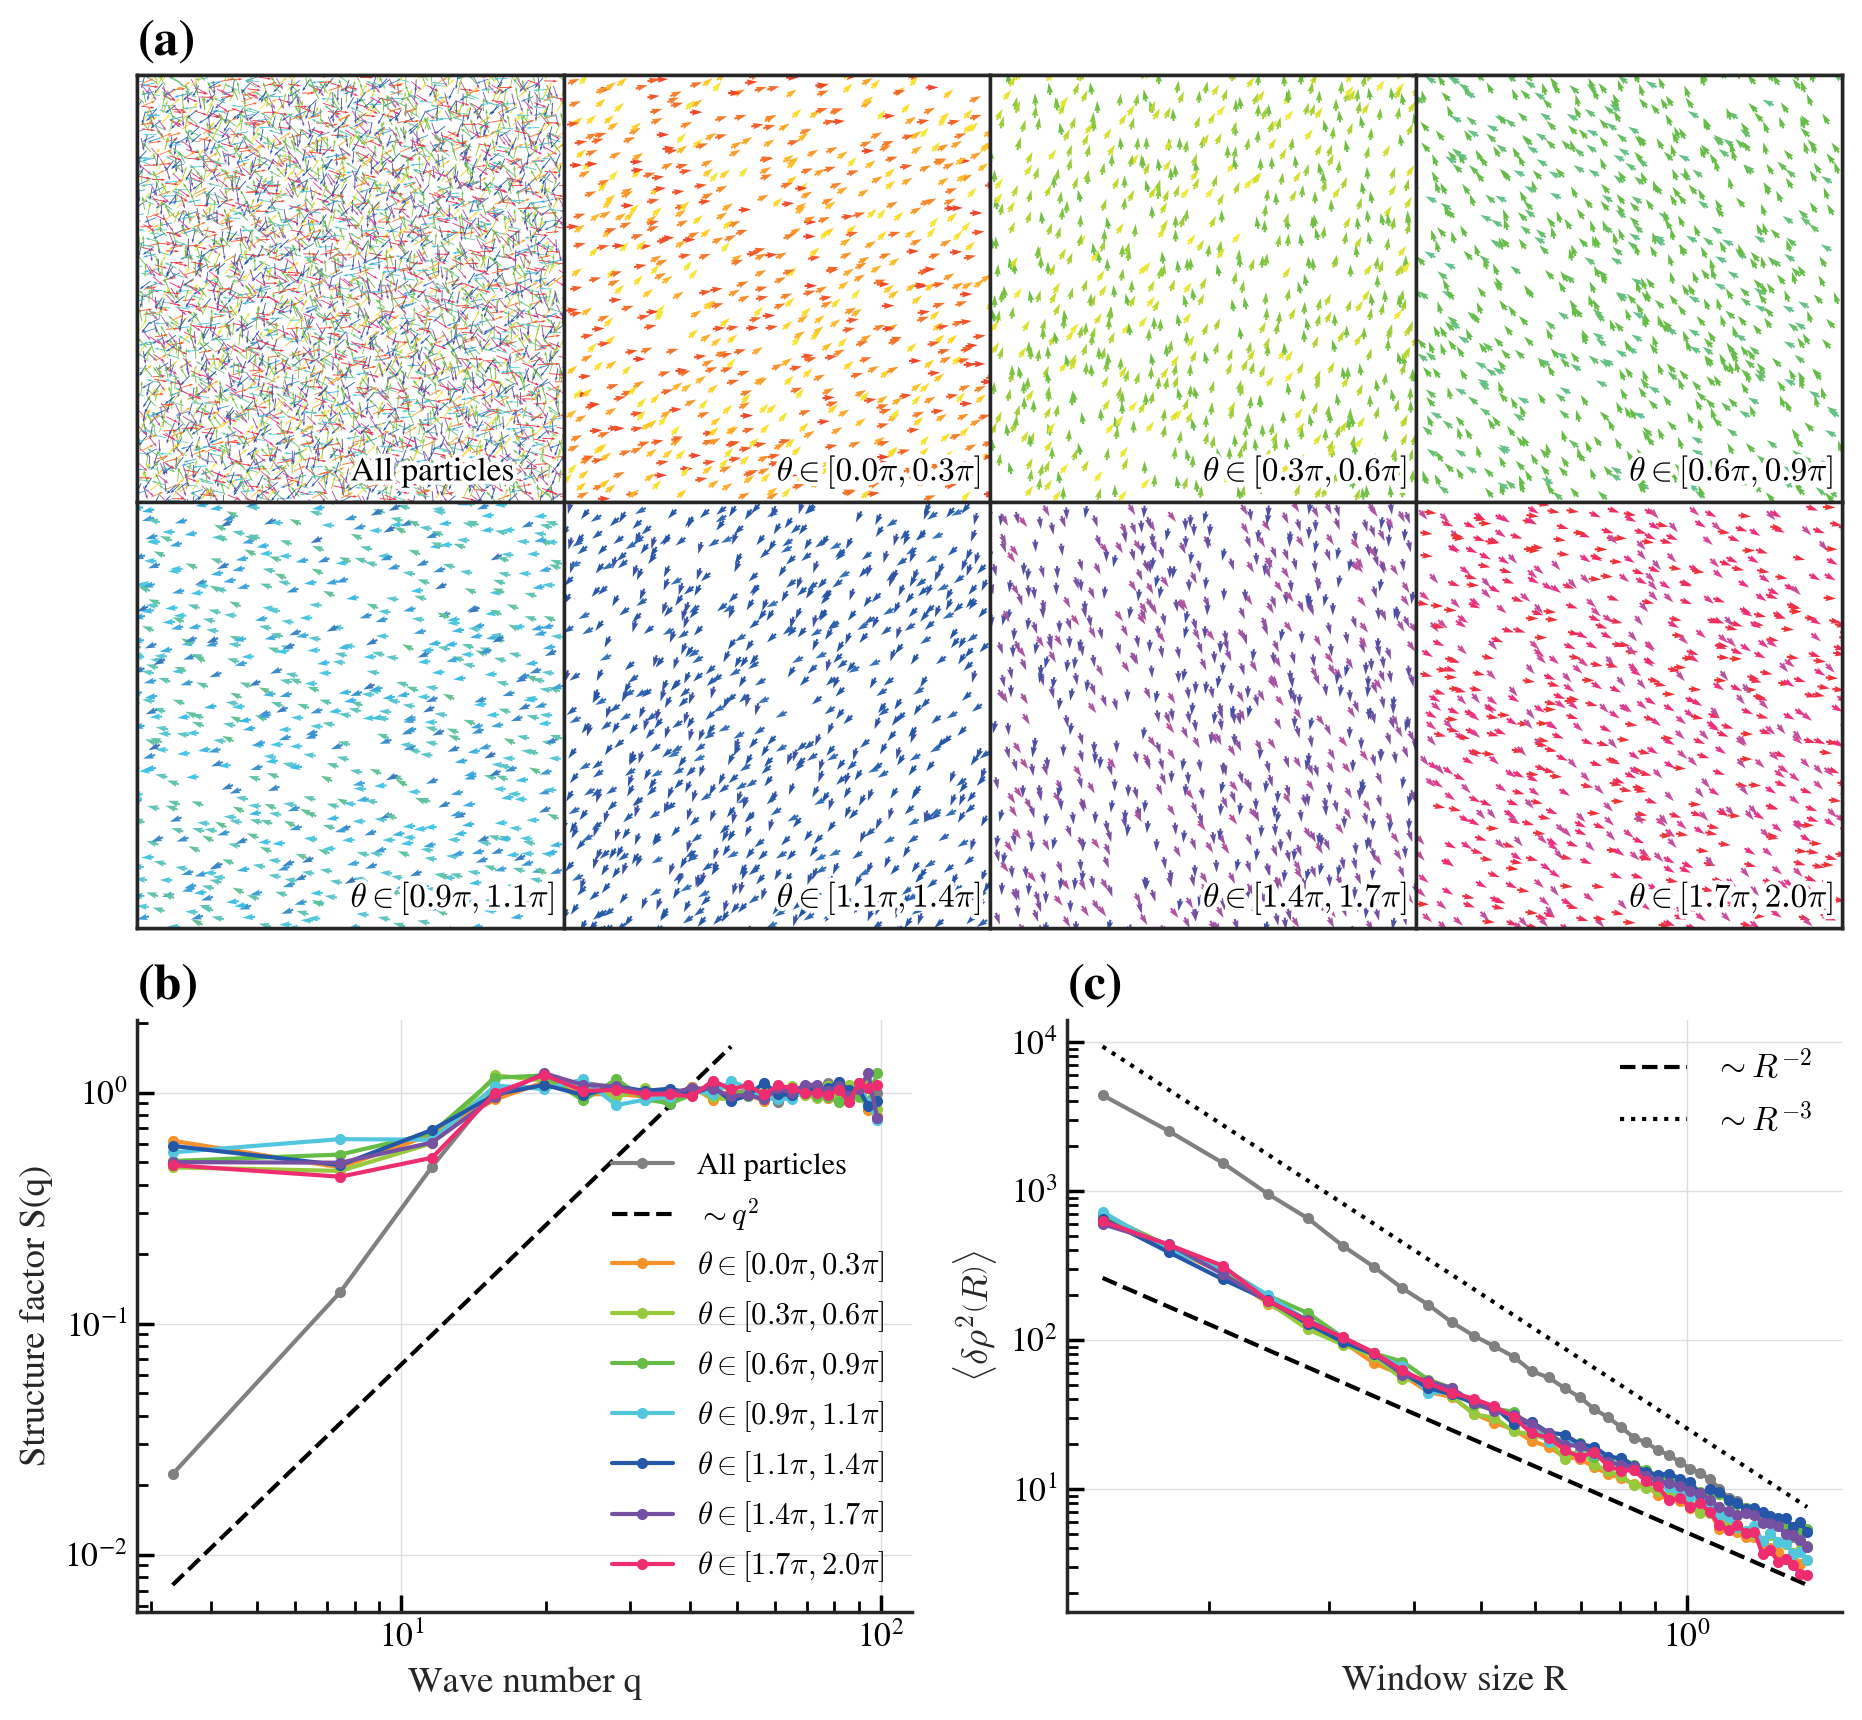

In [23]:
fig = plt.figure(figsize=(11, 11))
grid = gridspec.GridSpec(2, 1, height_ratios=[1.6, 1])
ax1 = fig.add_subplot(grid[0])

gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[1], width_ratios=[1, 1])
ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

# ax1
plot_sub_snapshots(sa, positionX, phaseTheta, 0, 2, 4, ax1, "All particles")
ax1.set_xlim(0, 4 * sa.model.boundaryLength)
ax1.set_ylim(0, 2 * sa.model.boundaryLength)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_aspect("equal")
# ax2
Sqs = Sqs_dict["all"]
ax2.loglog(qBinsValues, Sqs, 'o-', markersize=3, label="All particles", color="gray")
ax2.set_xlabel('Wave number q')
ax2.set_ylabel('Structure factor S(q)')
ax2.tick_params(which='both', direction="in")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True)
power_law = 2
sub_q_values = qBinsValues[qBinsValues < 50]
ax2.loglog(sub_q_values, sub_q_values ** power_law / 1500, '--', color="black",
           label=r'$\sim q^{' + str(power_law) + '}$')
# ax3
variance_rho = variance_rho_dict["all"]
ax3.loglog(l_values, variance_rho, 'o-', markersize=3, color="gray")
ax3.set_xlabel('Window size R')
ax3.set_ylabel(r'$\langle \delta \rho ^2\left( R \right) \rangle$')
ax3.tick_params(which='both', direction="in")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.grid(True)
power_law = 2
ax3.loglog(l_values, rho_0 / (l_values**power_law) / 20, '--', color="black",
           label=r'$\sim R^{' + str(-power_law) + '}$')
sub_l_values = l_values[(0.2 < l_values) & (l_values < 0.35)]
power_law = 3
sub_l_values = l_values # [l_values >= 0.4]
ax3.loglog(sub_l_values, rho_0 / (sub_l_values**power_law) / 4, ':', color="black",
           label=r'$\sim R^{' + str(-power_law) + '}$')


for i, idxs in enumerate(selectIdxs):
    key = r"$\theta \in [{:.1f}\pi, {:.1f}\pi]$".format(splitPhaseBin[i] / np.pi, splitPhaseBin[i + 1] / np.pi)
    subPositionX = positionX[idxs]
    subPhaseTheta = phaseTheta[idxs]
    meanPhaseTheta = (splitPhaseBin[i] + splitPhaseBin[i + 1]) / 2
    color = hexCmap(np.floor(256 - meanPhaseTheta / (2 * np.pi) * 256).astype(np.int32))
    # ax1
    plot_sub_snapshots(sa, subPositionX, subPhaseTheta, i + 1, 2, 4, ax1, key,
                       scale=16, width=0.005)
    # ax2
    Sqs = Sqs_dict[key]
    ax2.loglog(qBinsValues, Sqs, 'o-', markersize=3, label=key, color=color)
    # ax3
    variance_rho = variance_rho_dict[key]
    ax3.loglog(l_values, variance_rho, 'o-', markersize=3, color=color)
    
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_title(f"({chr(97 + i)})", fontsize=18, fontweight="bold",
                  va='top', ha='left', loc='left', pad=20)

ax2.legend(frameon=False, loc="lower right", fontsize=11)
ax3.legend(frameon=False)

ax1Pos = ax1.get_position()
ax1.set_position([ax1Pos.x0, ax1Pos.y0 - 0.05, ax1Pos.width, ax1Pos.height])

plt.savefig(f"{LOCAL_FIG_PATH}/phase_bins_Sq_and_variance_rho.pdf", bbox_inches='tight')